In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Imports 

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary 
import onnx 
import onnxruntime as ort
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
import random
import os
import datetime
import matplotlib.pyplot as plt

# Dataset Class 

In [2]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Data Loaders

In [3]:
def get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(256,256),
    split_ratio=(0.8,0.1,0.1),
    batch_sizes=(64,16,16),
    random_state=42
):
    # Collect file lists
    image_files, mask_files = [], []
    for img_dir, msk_dir in zip(image_dirs, mask_dirs):
        imgs = sorted([os.path.join(img_dir,f) for f in os.listdir(img_dir)
                    if f.lower().endswith(('.jpg','.png'))])
        msks = sorted([os.path.join(msk_dir,f) for f in os.listdir(msk_dir)
                    if f.lower().endswith(('.jpg','.png'))])
        assert len(imgs)==len(msks), f"Mismatch in {img_dir}"
        image_files.extend(imgs)
        mask_files.extend(msks)

    # Train/val/test split
    from sklearn.model_selection import train_test_split
    train_ratio, val_ratio, test_ratio = split_ratio
    train_imgs, temp_imgs, train_msks, temp_msks = train_test_split(
        image_files, mask_files, test_size=(1-train_ratio), random_state=random_state)
    val_prop = val_ratio/(val_ratio+test_ratio)
    val_imgs, test_imgs, val_msks, test_msks = train_test_split(
        temp_imgs, temp_msks, test_size=(1-val_prop), random_state=random_state)

    print(f"Total images: {len(image_files)}")
    print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # Transforms and Dataset
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])

    train_ds = SaliencyDataset(train_imgs, train_msks, transform)
    val_ds   = SaliencyDataset(val_imgs,   val_msks,   transform)
    test_ds  = SaliencyDataset(test_imgs,  test_msks,  transform)

    train_loader = DataLoader(train_ds, batch_size=batch_sizes[0], shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_sizes[1], shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_sizes[2], shuffle=False)

    return train_loader, val_loader, test_loader


# Defined Models 

In [4]:
class Saliency_RGB_v1(nn.Module):
    def __init__(self):
        super(Saliency_RGB_v1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
class Saliency_RGB_v2(nn.Module):
    def __init__(self):
        super(Saliency_RGB_v2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Model loader
def load_model(model_class, model_path, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

## Training Setup

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(HybridLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        return self.alpha * self.bce(inputs, targets) + (1 - self.alpha) * self.dice(inputs, targets)


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=100, log_prefix="exp", device="cuda"):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"./training_logs/{log_prefix}_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)

    train_losses, val_losses, lrs = [], [], []
    best_val_loss = float('inf')
    best_model_path = os.path.join(log_dir, "best_model.pth")

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate tracking
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        if scheduler:
            scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  Saved best model at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.grid(True)
    plt.savefig(os.path.join(log_dir, "loss_plot.png"))
    plt.show()

    # Optionally save CSV
    with open(os.path.join(log_dir, "loss_log.csv"), "w") as f:
        f.write("epoch,train_loss,val_loss,lr\n")
        for i in range(num_epochs):
            f.write(f"{i+1},{train_losses[i]:.4f},{val_losses[i]:.4f},{lrs[i]:.6f}\n")

    return best_model_path

## Evaluation Setup

In [8]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    min_frac = float('inf')
    for _, masks in dataloader:
        m_np = masks.numpy()  # shape (B,1,H,W)
        for m in m_np:
            binary = (m[0] >= bin_thresh).astype(np.uint8)
            total = binary.size
            salient = binary.sum()
            if salient > 0:
                min_frac = min(min_frac, salient/total)
    if min_frac == float('inf'):
        raise RuntimeError("No non-empty masks found.")
    return min_frac

def evaluate_model(
    model,
    dataloader,
    device,
    bin_thresh=0.5,
    area_frac=None,
    compute_area_frac=False,
    beta2=0.3,
    save_model_path=None,
    visualize=False
):
    model.eval()
    if compute_area_frac:
        area_frac = compute_min_pixel_fraction(dataloader, bin_thresh)
        print(f"[INFO] Computed area_frac={area_frac:.6f} from GT masks")

    # Metrics accumulators
    mae_sum = 0
    prec_sum = 0
    rec_sum = 0
    iou_list = []
    y_true, y_pred = [], []
    n = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images).cpu().numpy()
            gts = masks.cpu().numpy()

            for pred, gt in zip(outputs, gts):
                pred = pred[0]; gt = gt[0]
                # MAE
                mae_sum += np.mean(np.abs(pred - gt))
                # Binary masks
                pbin = (pred >= bin_thresh).astype(np.uint8)
                gbin = (gt   >= bin_thresh).astype(np.uint8)
                # Precision/Recall
                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()
                prec = tp / (tp+fp+1e-8)
                rec  = tp / (tp+fn+1e-8)
                prec_sum += prec; rec_sum += rec
                # IoU
                inter = (pbin & gbin).sum()
                union = (pbin | gbin).sum()
                iou_list.append(inter/union if union>0 else float(inter==0))
                # Object-presence
                def has_obj(mask):
                    return (mask.sum() / mask.size) > area_frac
                y_true.append(has_obj(gbin))
                y_pred.append(has_obj(pbin))

                n += 1

    # Final aggregations
    mae      = mae_sum / n
    precision= prec_sum / n
    recall   = rec_sum / n
    fbeta    = (1+beta2)*precision*recall/(beta2*precision+recall+1e-8)
    miou     = np.mean(iou_list)
    tp_obj   = sum(t and p for t,p in zip(y_true,y_pred))
    fn_obj   = sum(t and not p for t,p in zip(y_true,y_pred))
    obj_recl = tp_obj / (tp_obj+fn_obj+1e-6)

    # Print
    print("\n=== Evaluation Results ===")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")
    print(f"Obj Presence R : {obj_recl:.4f}")
    print(f"Binarize thres.: {bin_thresh:.2f}")
    print(f"Area fraction  : {area_frac:.6f}")

    # Optional visualize
    if visualize:
        img, gt_mask = images[0], masks[0][0]
        pred_mask = outputs[0][0]
        fig, axs = plt.subplots(1,3,figsize=(12,4))
        axs[0].imshow(img.permute(1,2,0).cpu());     axs[0].set_title("Image")
        axs[1].imshow(gt_mask.cpu(),cmap='gray');   axs[1].set_title("GT Mask")
        axs[2].imshow(pred_mask,cmap='gray');       axs[2].set_title("Pred Mask")
        plt.show()

    # Optional save model
    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f"[INFO] Model saved to {save_model_path}")

    return {
        "mae":mae, "precision":precision, "recall":recall,
        "f_beta":fbeta, "miou":miou, "obj_recall":obj_recl,
        "bin_thresh":bin_thresh, "area_frac":area_frac
    }

### 1 - Simulated RGB dataset

In [11]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

Total images: 2751
Train: 1925, Val: 413, Test: 413


#### Saliency_RGB_v1

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.2149 | Val Loss: 0.1269
  Saved best model at epoch 1 (Val Loss: 0.1269)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1314 | Val Loss: 0.1222
  Saved best model at epoch 2 (Val Loss: 0.1222)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1271 | Val Loss: 0.1270
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1192 | Val Loss: 0.1023
  Saved best model at epoch 4 (Val Loss: 0.1023)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1134 | Val Loss: 0.0974
  Saved best model at epoch 5 (Val Loss: 0.0974)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1109 | Val Loss: 0.0962
  Saved best model at epoch 6 (Val Loss: 0.0962)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1019 | Val Loss: 0.0934
  Saved best model at epoch 7 (Val Loss: 0.0934)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1012 | Val Loss: 0.0899
  Saved best model at epoch 8 (Val Loss: 0.0899)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.0921 | Val Loss: 0.0830
  Saved best model at epoch 9 (Val L

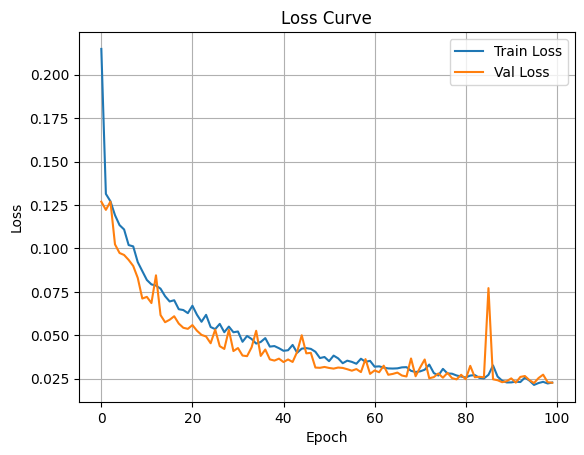

'./training_logs/RGB_v1_d1_fixed_bce_20250514_081726/best_model.pth'

In [12]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, log_prefix="RGB_v1_d1_fixed_bce")


=== Evaluation Results ===
MAE            : 0.0108
Precision      : 0.7978
Recall         : 0.7511
Fβ (β²=0.3): 0.7865
Mean IoU       : 0.7014
Obj Presence R : 0.9973
Binarize thres.: 0.50
Area fraction  : 0.001000


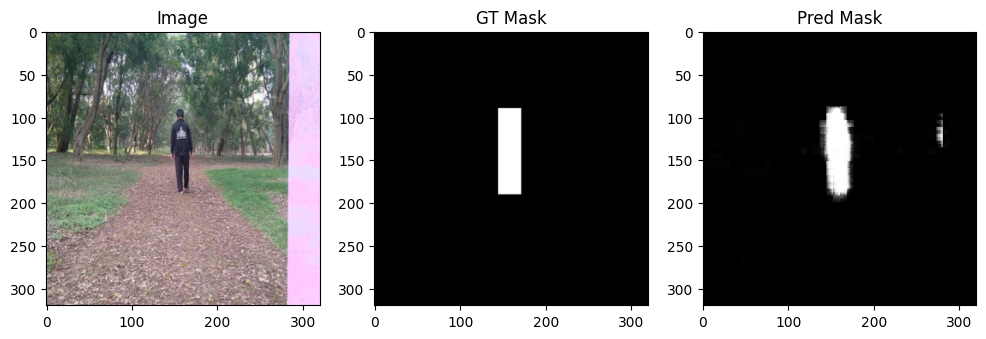

In [13]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False,
    visualize=True
)

In [14]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    compute_area_frac=True
)

[INFO] Computed area_frac=0.000947 from GT masks

=== Evaluation Results ===
MAE            : 0.0108
Precision      : 0.7978
Recall         : 0.7511
Fβ (β²=0.3): 0.7865
Mean IoU       : 0.7014
Obj Presence R : 0.9973
Binarize thres.: 0.50
Area fraction  : 0.000947


In [15]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    compute_area_frac=True
)

[INFO] Computed area_frac=0.001055 from GT masks

=== Evaluation Results ===
MAE            : 0.0108
Precision      : 0.7357
Recall         : 0.7901
Fβ (β²=0.3): 0.7476
Mean IoU       : 0.6639
Obj Presence R : 1.0000
Binarize thres.: 0.30
Area fraction  : 0.001055


#### Saliency_RGB_v2

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.4322 | Val Loss: 0.1588
  Saved best model at epoch 1 (Val Loss: 0.1588)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1514 | Val Loss: 0.1283
  Saved best model at epoch 2 (Val Loss: 0.1283)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1383 | Val Loss: 0.1279
  Saved best model at epoch 3 (Val Loss: 0.1279)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1373 | Val Loss: 0.1237
  Saved best model at epoch 4 (Val Loss: 0.1237)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1363 | Val Loss: 0.1231
  Saved best model at epoch 5 (Val Loss: 0.1231)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1329 | Val Loss: 0.1206
  Saved best model at epoch 6 (Val Loss: 0.1206)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1292 | Val Loss: 0.1151
  Saved best model at epoch 7 (Val Loss: 0.1151)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1253 | Val Loss: 0.1097
  Saved best model at epoch 8 (Val Loss: 0.1097)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1228 | Val 

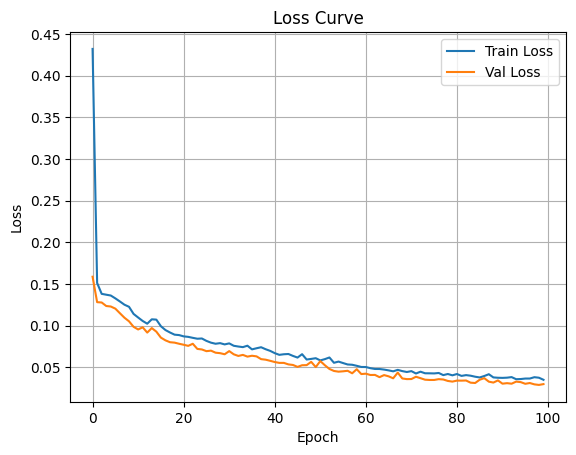


=== Evaluation Results ===
MAE            : 0.0143
Precision      : 0.7234
Recall         : 0.6021
Fβ (β²=0.3): 0.6913
Mean IoU       : 0.6030
Obj Presence R : 0.9176
Binarize thres.: 0.50
Area fraction  : 0.001000


In [16]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, log_prefix="RGB_v2_d1_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


=== Evaluation Results ===
MAE            : 0.0143
Precision      : 0.7234
Recall         : 0.6021
Fβ (β²=0.3): 0.6913
Mean IoU       : 0.6030
Obj Presence R : 0.9176
Binarize thres.: 0.50
Area fraction  : 0.001000


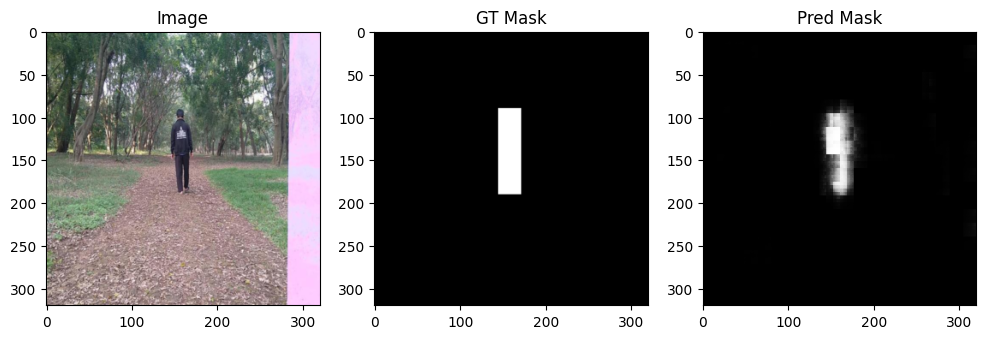

In [17]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False,
    visualize=True
)

In [18]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    compute_area_frac=True
)

[INFO] Computed area_frac=0.001055 from GT masks

=== Evaluation Results ===
MAE            : 0.0143
Precision      : 0.6645
Recall         : 0.6812
Fβ (β²=0.3): 0.6683
Mean IoU       : 0.6027
Obj Presence R : 0.9388
Binarize thres.: 0.30
Area fraction  : 0.001055


### 2 - Military paper RGB dataset

In [13]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB"
]

train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

Total images: 2100
Train: 1469, Val: 315, Test: 316


#### Saliency_RGB_v1

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.3387 | Val Loss: 0.2168
  Saved best model at epoch 1 (Val Loss: 0.2168)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.2083 | Val Loss: 0.1939
  Saved best model at epoch 2 (Val Loss: 0.1939)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1968 | Val Loss: 0.1863
  Saved best model at epoch 3 (Val Loss: 0.1863)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1901 | Val Loss: 0.1879
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1897 | Val Loss: 0.1790
  Saved best model at epoch 5 (Val Loss: 0.1790)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1828 | Val Loss: 0.1745
  Saved best model at epoch 6 (Val Loss: 0.1745)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1796 | Val Loss: 0.1706
  Saved best model at epoch 7 (Val Loss: 0.1706)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1763 | Val Loss: 0.1699
  Saved best model at epoch 8 (Val Loss: 0.1699)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1728 | Val Loss: 0.1663
  Saved best model at epoch 9 (Val L

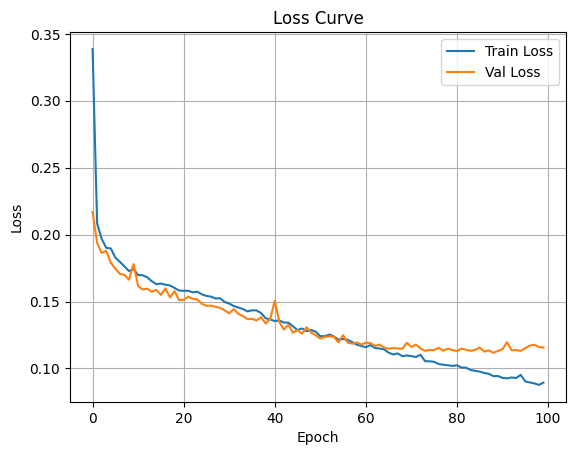


=== Evaluation Results ===
MAE            : 0.0517
Precision      : 0.5945
Recall         : 0.3497
Fβ (β²=0.3): 0.5118
Mean IoU       : 0.2906
Obj Presence R : 0.8956
Binarize thres.: 0.50
Area fraction  : 0.001000


In [20]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, log_prefix="RGB_v1_d2_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

#### Saliency_RGB_v2

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.5336 | Val Loss: 0.2681
  Saved best model at epoch 1 (Val Loss: 0.2681)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.2443 | Val Loss: 0.2180
  Saved best model at epoch 2 (Val Loss: 0.2180)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.2194 | Val Loss: 0.2068
  Saved best model at epoch 3 (Val Loss: 0.2068)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.2080 | Val Loss: 0.1985
  Saved best model at epoch 4 (Val Loss: 0.1985)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.2041 | Val Loss: 0.1950
  Saved best model at epoch 5 (Val Loss: 0.1950)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.2015 | Val Loss: 0.1925
  Saved best model at epoch 6 (Val Loss: 0.1925)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.2001 | Val Loss: 0.1915
  Saved best model at epoch 7 (Val Loss: 0.1915)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1991 | Val Loss: 0.1901
  Saved best model at epoch 8 (Val Loss: 0.1901)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1972 | Val 

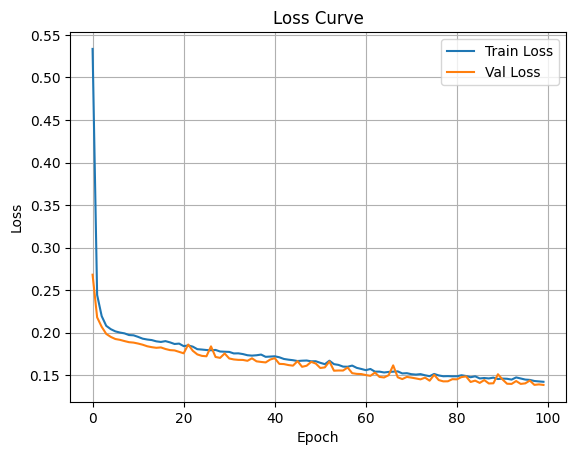


=== Evaluation Results ===
MAE            : 0.0799
Precision      : 0.4007
Recall         : 0.1026
Fβ (β²=0.3): 0.2399
Mean IoU       : 0.0886
Obj Presence R : 0.5285
Binarize thres.: 0.50
Area fraction  : 0.001000


In [14]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="RGB_v2_d2_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

### 3 - RGB military scenario dataset

In [10]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/images"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/saliency_masks"
]


train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

Total images: 26315
Train: 18420, Val: 3947, Test: 3948


#### Saliency_RGB_v1

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/50] | LR: 0.001000 | Train Loss: 0.5352 | Val Loss: 0.5112
  Saved best model at epoch 1 (Val Loss: 0.5112)
Epoch [2/50] | LR: 0.001000 | Train Loss: 0.5120 | Val Loss: 0.5049
  Saved best model at epoch 2 (Val Loss: 0.5049)
Epoch [3/50] | LR: 0.001000 | Train Loss: 0.5074 | Val Loss: 0.4999
  Saved best model at epoch 3 (Val Loss: 0.4999)
Epoch [4/50] | LR: 0.001000 | Train Loss: 0.5028 | Val Loss: 0.4970
  Saved best model at epoch 4 (Val Loss: 0.4970)
Epoch [5/50] | LR: 0.001000 | Train Loss: 0.5005 | Val Loss: 0.4990
Epoch [6/50] | LR: 0.001000 | Train Loss: 0.4984 | Val Loss: 0.4989
Epoch [7/50] | LR: 0.001000 | Train Loss: 0.4958 | Val Loss: 0.4915
  Saved best model at epoch 7 (Val Loss: 0.4915)
Epoch [8/50] | LR: 0.001000 | Train Loss: 0.4939 | Val Loss: 0.4945
Epoch [9/50] | LR: 0.001000 | Train Loss: 0.4919 | Val Loss: 0.4859
  Saved best model at epoch 9 (Val Loss: 0.4859)
Epoch [10/50] | LR: 0.001000 | Train Loss: 0.4914 | Val Loss: 0.4847
  Saved best model at epo

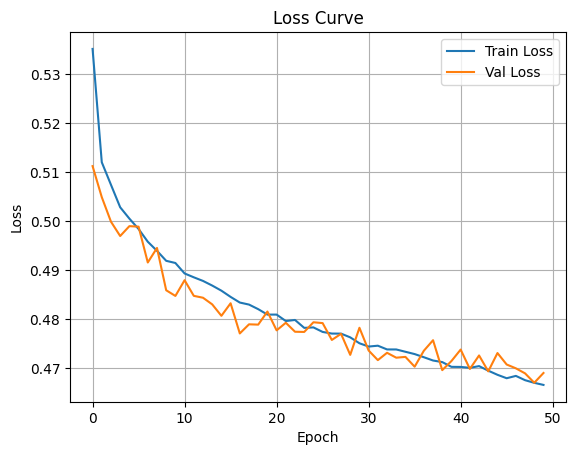


=== Evaluation Results ===
MAE            : 0.3103
Precision      : 0.6047
Recall         : 0.5293
Fβ (β²=0.3): 0.5855
Mean IoU       : 0.3586
Obj Presence R : 0.9982
Binarize thres.: 0.50
Area fraction  : 0.001000


In [11]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50,  log_prefix="RGB_v1_d3_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

#### Saliency_RGB_v2

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/50] | LR: 0.001000 | Train Loss: 0.5847 | Val Loss: 0.5354
  Saved best model at epoch 1 (Val Loss: 0.5354)
Epoch [2/50] | LR: 0.001000 | Train Loss: 0.5193 | Val Loss: 0.5024
  Saved best model at epoch 2 (Val Loss: 0.5024)
Epoch [3/50] | LR: 0.001000 | Train Loss: 0.4992 | Val Loss: 0.4894
  Saved best model at epoch 3 (Val Loss: 0.4894)
Epoch [4/50] | LR: 0.001000 | Train Loss: 0.4920 | Val Loss: 0.4820
  Saved best model at epoch 4 (Val Loss: 0.4820)
Epoch [5/50] | LR: 0.001000 | Train Loss: 0.4862 | Val Loss: 0.4772
  Saved best model at epoch 5 (Val Loss: 0.4772)
Epoch [6/50] | LR: 0.001000 | Train Loss: 0.4836 | Val Loss: 0.4750
  Saved best model at epoch 6 (Val Loss: 0.4750)
Epoch [7/50] | LR: 0.001000 | Train Loss: 0.4810 | Val Loss: 0.4733
  Saved best model at epoch 7 (Val Loss: 0.4733)
Epoch [8/50] | LR: 0.001000 | Train Loss: 0.4779 | Val Loss: 0.4714
  Saved best model at epoch 8 (Val Loss: 0.4714)
Epoch [9/50] | LR: 0.001000 | Train Loss: 0.4752 | Val Loss: 0.4

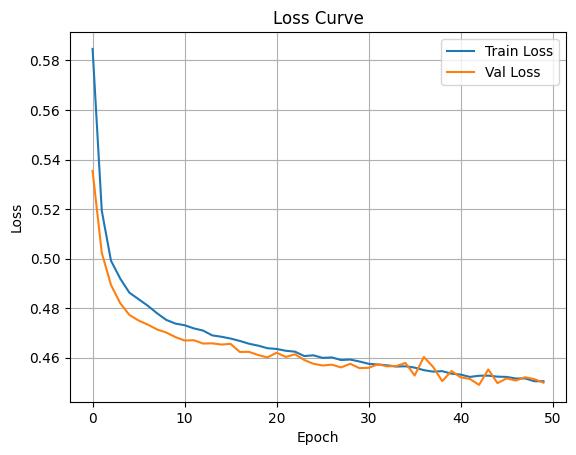


=== Evaluation Results ===
MAE            : 0.2946
Precision      : 0.6251
Recall         : 0.5051
Fβ (β²=0.3): 0.5926
Mean IoU       : 0.3604
Obj Presence R : 0.9713
Binarize thres.: 0.50
Area fraction  : 0.001000


In [12]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, log_prefix="RGB_v2_d3_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

###  4 - RGB combined dataset

In [9]:
# paths:
image_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/images",
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB",
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB"
]
mask_dirs = [
    "/home/deepaksr/project/Saliency_datasets/RGB_only/saliency_masks",
    "/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB",
    "/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]


train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(32,8,8)
)

Total images: 31166
Train: 21816, Val: 4675, Test: 4675


#### Saliency_RGB_v1

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_RGB_v1().to(device)
# Load the saved state_dict from the .pth file
checkpoint_path = "/home/deepaksr/project/Project_files_2/training_logs/RGB_v1_d4_combined_fixed_bce_20250521_200953/best_model.pth"  # Update this path
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set the model to evaluation mode
model.eval()
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

/tmp/ipykernel_3207032/1419373773.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))



=== Evaluation Results ===
MAE            : 0.3120
Precision      : 0.4894
Recall         : 0.0869
Fβ (β²=0.3): 0.2365
Mean IoU       : 0.0713
Obj Presence R : 0.7838
Binarize thres.: 0.50
Area fraction  : 0.001000
